In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from geopy.geocoders import Nominatim

%matplotlib inline
cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

HousePrice1 = pd.read_csv("HousePrice1.csv")

Current working directory: /Users/chereowang27/NYCDSA/Machine_Learning_I/Machine_Learning_Project/Ames_Housing_ML


In [109]:
HousePrice1.columns

Index(['Unnamed: 0', 'MapRefNo', 'Prop_Addr', 'Unnamed: 0.1', 'PID',
       'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'Garage

In [2]:
HousePrice1['ppsqft']= HousePrice1["SalePrice"]/HousePrice1['GrLivArea']
HousePrice1['mo_Yr_sold'] = HousePrice1.MoSold.astype(str) + '/' + HousePrice1.YrSold.astype(str)
HousePrice1['mo_Yr_sold'] = pd.to_datetime(HousePrice1['mo_Yr_sold'])
HousePrice1_gr = HousePrice1.groupby(['mo_Yr_sold','Neighborhood'])[['SalePrice']].median()\
         .reset_index()
HousePrice1_gr

,mo_Yr_sold,Neighborhood,SalePrice
0,2006-01-01,CollgCr,232500.0
1,2006-01-01,Gilbert,172400.0
2,2006-01-01,NAmes,138000.0
3,2006-01-01,NWAmes,181000.0
4,2006-01-01,SWISU,80000.0
...,...,...,...
891,2010-07-01,Crawfor,257500.0
892,2010-07-01,Edwards,80000.0
893,2010-07-01,IDOTRR,55000.0
894,2010-07-01,NAmes,161000.0


<Figure size 144000x7200 with 0 Axes>

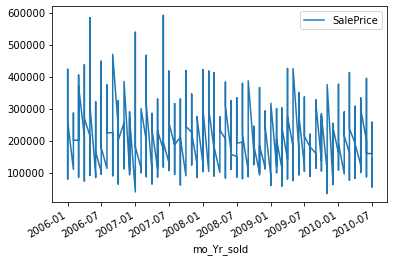

In [3]:
from matplotlib.pyplot import figure
figure(figsize=(2000, 100))
g = HousePrice1_gr.plot(x = "mo_Yr_sold", y = 'SalePrice')
plt.show()

In [111]:
log_p = np.log10(HousePrice1['SalePrice'])

#Feature selection
HousePrice2 = HousePrice1.drop(['Unnamed: 0', 'MapRefNo','PID','Unnamed: 0.1', 'Prop_Addr'], \
                               axis = 1)
num_features = HousePrice2._get_numeric_data()  \
 .drop(['MSSubClass', 'SalePrice'], axis = 1)
num_features['bath'] = num_features['FullBath'] + 0.5*num_features['HalfBath']

col = HousePrice2.columns
catcol = [col for col in HousePrice2.columns if col not in num_features.columns]

In [112]:
num_features.columns

Index(['GrLivArea', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'ppsqft', 'bath'],
      dtype='object')

In [113]:
cat_features = HousePrice1[catcol]
# group Neighborhood
p_mean_by_nb = HousePrice1.groupby('Neighborhood')['SalePrice'].mean() 
nb_bin = pd.qcut(p_mean_by_nb, q = [0,0.25,.5,.75,1],
                 labels = ['tier1','tier2','tier3','tier4'])\
                .to_dict()
                 #tier1 < tier2 < tier3 < tier4
cat_features['NbPriceTier'] = cat_features['Neighborhood'].map(nb_bin)                              

features = pd.concat([num_features, cat_features], axis = 1) \
           .drop(['GrLivArea','FullBath', 'HalfBath', \
                  'BsmtFullBath', 'BsmtHalfBath', \
                  'BsmtFinSF1','SalePrice','LandSlope','ExterQual', \
                  'Condition1','Condition2', \
                  'BsmtFinType1','BsmtFinType2', \
                  'BsmtQual', 'GarageQual','MoSold','mo_Yr_sold',   \
                  'BsmtFinSF2', 'BsmtUnfSF','Neighborhood','ppsqft'],axis = 1)

<ipython-input-113-51557a0f9efc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_features['NbPriceTier'] = cat_features['Neighborhood'].map(nb_bin)


In [114]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 59 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    2624 non-null   float64
 1   LotArea        2624 non-null   int64  
 2   OverallQual    2624 non-null   int64  
 3   OverallCond    2624 non-null   int64  
 4   YearBuilt      2624 non-null   int64  
 5   YearRemodAdd   2624 non-null   int64  
 6   MasVnrArea     2624 non-null   float64
 7   TotalBsmtSF    2624 non-null   float64
 8   1stFlrSF       2624 non-null   int64  
 9   2ndFlrSF       2624 non-null   int64  
 10  LowQualFinSF   2624 non-null   int64  
 11  BedroomAbvGr   2624 non-null   int64  
 12  KitchenAbvGr   2624 non-null   int64  
 13  TotRmsAbvGrd   2624 non-null   int64  
 14  Fireplaces     2624 non-null   int64  
 15  GarageYrBlt    2624 non-null   float64
 16  GarageCars     2624 non-null   float64
 17  GarageArea     2624 non-null   float64
 18  WoodDeck

In [115]:
catcol = [col for col in features.columns if col not in num_features.columns]

In [116]:
# One Hot Encoding
features= pd.get_dummies(features, columns = catcol, drop_first = True)

y = HousePrice1['SalePrice']



In [135]:
#check cnts of each level in dummy variables
cnt = features.iloc[:, 27:192].sum()
cnt

MSSubClass_30             125
MSSubClass_40               6
MSSubClass_45              18
MSSubClass_50             263
MSSubClass_60             507
                         ... 
SaleCondition_Family       17
SaleCondition_Normal     2457
SaleCondition_Partial      83
NbPriceTier_tier2         811
NbPriceTier_tier3         674
Length: 165, dtype: int64

In [65]:
from sklearn import linear_model, datasets
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
ridge = Ridge()
lasso = Lasso()
net = ElasticNet()
from sklearn import datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = 0.3, random_state = 0)



In [66]:
X_train.shape

(1836, 193)

In [67]:
y_train.shape

(1836,)

In [68]:
ridge.set_params(alpha = 0, normalize = False )
ridge.fit(X_train, y_train)
print('the ridge intercept is: %.2f' %(ridge.intercept_))
pd.Series(ridge.coef_, index = features.columns)

the ridge intercept is: 485276585456322112.00


LotFrontage                -15.967416
LotArea                      0.892706
OverallQual               7792.706140
OverallCond               5790.675827
YearBuilt                  433.789297
                             ...     
SaleCondition_Normal    -12061.784281
SaleCondition_Partial    -1589.656365
NbPriceTier_tier2        -9801.421793
NbPriceTier_tier3        -8753.224393
NbPriceTier_tier4        11846.225761
Length: 193, dtype: float64

In [69]:
#Coefficient Plot of Ridge vs. Penalization Strength alpha
alphas = np.arange(0,20)
ridge.set_params(normalize=True)
coefs  = []
scores = []
for alpha in alphas:
        ridge.set_params(alpha=alpha)
        ridge.fit(features, y)  
        coefs.append(ridge.coef_)
        scores.append(ridge.score(features, y))
coefs = pd.DataFrame(coefs, index = alphas, columns = features.columns)  
coefs

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,SaleType_VWD,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,NbPriceTier_tier2,NbPriceTier_tier3,NbPriceTier_tier4
0,32.240081,0.297111,7629.368355,5814.460692,379.126959,68.450336,37.207979,29.213339,49.818218,65.772885,...,-7011.741925,4425.590139,-6226.020737,20779.857461,-19886.769946,7236.648649,21775.660823,4776.477136,6708.806198,30850.933856
1,111.505349,0.312074,5801.488748,1814.716082,84.590437,151.019452,29.206708,16.947094,19.420853,8.519108,...,-13282.894164,-1458.780551,-8580.973420,5519.285428,-17636.318354,51.629755,9587.749317,-3930.296086,-2185.442973,16777.993566
2,105.530307,0.276343,4591.875725,1009.352477,74.100593,136.166137,23.394611,13.387583,15.327827,6.037294,...,-10164.510404,-1737.782458,-5381.901336,3206.178024,-12118.317584,-1019.416373,8656.697396,-3705.582213,-1383.503537,13489.041240
3,97.344431,0.246862,3931.934702,624.734931,69.788774,124.999509,20.069769,11.423498,13.064647,4.943766,...,-8121.587120,-1764.823300,-3805.634432,2094.657964,-9143.875304,-1436.744457,7981.173327,-3376.803843,-810.227054,11559.547416
4,89.884289,0.223145,3488.813255,402.371535,66.709180,116.121780,17.789532,10.094066,11.525409,4.276034,...,-6747.514828,-1726.394788,-2942.033044,1437.762895,-7306.963082,-1613.894521,7423.560209,-3085.691417,-431.830315,10228.404990
5,83.394825,0.203775,3159.680454,260.671317,64.038655,108.727055,16.079756,9.104104,10.376179,3.806784,...,-5769.110232,-1665.945209,-2422.369999,1008.138488,-6066.112072,-1682.497907,6946.242654,-2838.309563,-175.688644,9230.307523
6,77.770781,0.187662,2900.391219,164.763963,61.578706,102.384938,14.727799,8.324799,9.470665,3.450557,...,-5038.944948,-1598.784900,-2085.429743,709.398751,-5174.509665,-1696.751963,6530.349434,-2627.823139,2.658935,8442.495233
7,72.869489,0.174036,2688.152719,97.122380,59.272287,96.839590,13.620354,7.688502,8.731458,3.166740,...,-4473.664527,-1531.200641,-1853.205304,492.914346,-4504.402800,-1682.281568,6163.700846,-2447.110307,129.684376,7798.579246
8,68.565263,0.162348,2509.707799,47.974981,57.099873,91.924341,12.690012,7.155321,8.112577,2.933039,...,-4023.184785,-1465.901845,-1684.738503,331.304327,-3983.263030,-1652.320188,5837.540672,-2290.387229,221.689735,7258.803287
9,64.756062,0.152202,2356.675413,11.462467,55.052192,87.522860,11.893473,6.699782,7.584475,2.735954,...,-3655.751465,-1404.013725,-1557.080834,207.932419,-3566.945689,-1614.124623,5545.233171,-2153.166271,289.107390,6797.568717


Text(0, 0.5, 'slope values')

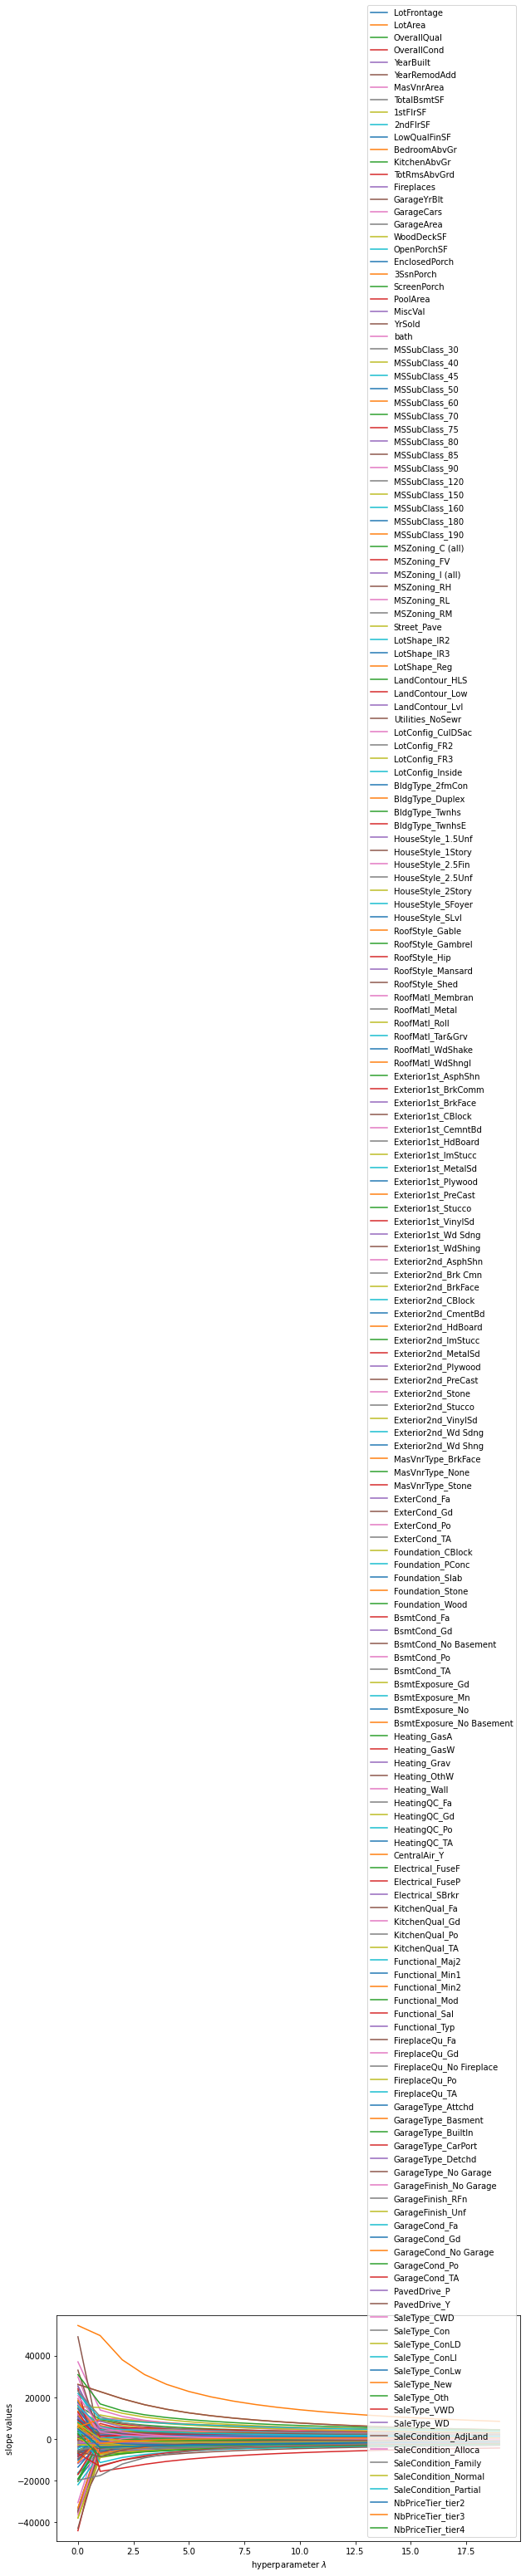

In [70]:
plt.rcParams['figure.figsize'] = (10,5)
for name in coefs.columns:
    plt.plot(coefs.index, coefs[name], label=name)
plt.legend(loc=4)   
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')

Text(0, 0.5, '$R^2$')

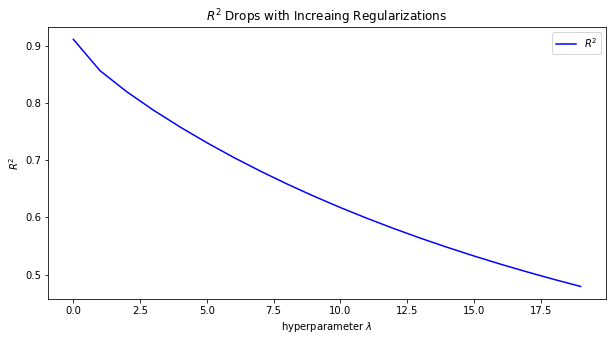

In [71]:
plt.plot(alphas, scores, c='b', label=r'$R^2$')
plt.legend(loc=1)
plt.title(r'$R^2$ Drops with Increaing Regularizations')
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

In [72]:
lasso = Lasso()
alphas = np.linspace(0.1,20.1,20)
lasso.set_params(normalize=False)
coefs_lasso  = []
for alpha in alphas: 
    lasso.set_params(alpha=alpha)
    lasso.fit(features, y)
    coefs_lasso.append(lasso.coef_)
    
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = features.columns)  
coefs_lasso
    

/Users/chereowang27/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 669789365957.9379, tolerance: 1506141295.56257
  model = cd_fast.enet_coordinate_descent(
/Users/chereowang27/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482510673620.65356, tolerance: 1506141295.56257
  model = cd_fast.enet_coordinate_descent(


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,SaleType_VWD,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,NbPriceTier_tier2,NbPriceTier_tier3,NbPriceTier_tier4
0.100000,32.705862,0.298428,7623.661914,5824.376215,378.802867,68.144557,37.237906,29.217637,49.856580,65.809996,...,-6811.042040,4391.215118,-6443.644337,20417.330204,-19908.068388,7186.988303,21709.388435,4768.976036,6698.305973,30855.310046
1.152632,33.476280,0.300547,7645.850767,5848.042862,376.272784,69.620697,37.372598,29.244891,49.886914,65.627524,...,-4685.544256,3892.763510,-5199.817894,18614.265360,-19895.972656,7069.702636,21822.751488,4681.731951,6576.663196,30767.542836
2.205263,33.415913,0.301646,7681.315312,5862.701667,375.996680,71.546477,37.411148,29.264707,49.870367,65.467316,...,-2455.061084,3422.202435,-3688.237226,17175.327581,-19861.175675,6977.610003,21996.974412,4608.497541,6479.565305,30682.577766
3.257895,33.093455,0.303153,7719.548971,5876.109170,375.527869,72.890131,37.425734,29.273238,49.865380,65.384030,...,-89.959916,3037.025214,-2151.321175,15795.805272,-19767.102412,6928.456914,22214.470806,4541.365690,6381.981731,30573.005829
4.310526,32.741147,0.305001,7750.125217,5883.965788,375.100525,74.273903,37.482860,29.277599,49.834491,65.252370,...,-0.000000,2609.977752,-480.983517,14462.995113,-19603.346381,6929.069969,22525.001963,4505.310522,6314.207555,30489.649035
5.363158,32.310344,0.306673,7776.519806,5892.882486,374.194772,75.366328,37.567719,29.290096,49.761094,65.104044,...,-0.000000,2201.258719,-0.000000,13056.742698,-19444.244181,6888.661476,22806.293629,4463.690765,6245.669383,30400.238536
6.415789,32.076971,0.308138,7800.109538,5904.746372,373.218547,76.279133,37.661756,29.297515,49.696506,64.948746,...,-0.000000,1836.173056,-0.000000,11685.371352,-19252.408036,6870.519794,23105.669730,4424.257348,6183.503179,30308.766000
7.468421,31.991717,0.309474,7820.759959,5918.617921,372.188086,77.090402,37.743026,29.281519,49.666541,64.808550,...,-0.000000,1494.038505,-0.000000,10339.434939,-19053.638118,6870.888246,23414.177839,4381.188122,6117.572603,30208.263322
8.521053,32.032913,0.310866,7835.643566,5932.896501,371.162386,77.718108,37.821771,29.252045,49.664870,64.634101,...,-0.000000,1155.182013,-0.000000,8908.974587,-18872.238062,6862.626874,23708.562019,4340.016311,6055.854418,30110.587641
9.573684,31.680463,0.312150,7851.181673,5943.244950,370.203218,78.385069,37.904493,29.229472,49.688445,64.447689,...,-0.000000,848.271137,-0.000000,7423.093233,-18705.939398,6845.567696,23524.119727,4288.879040,5989.055617,30023.518101


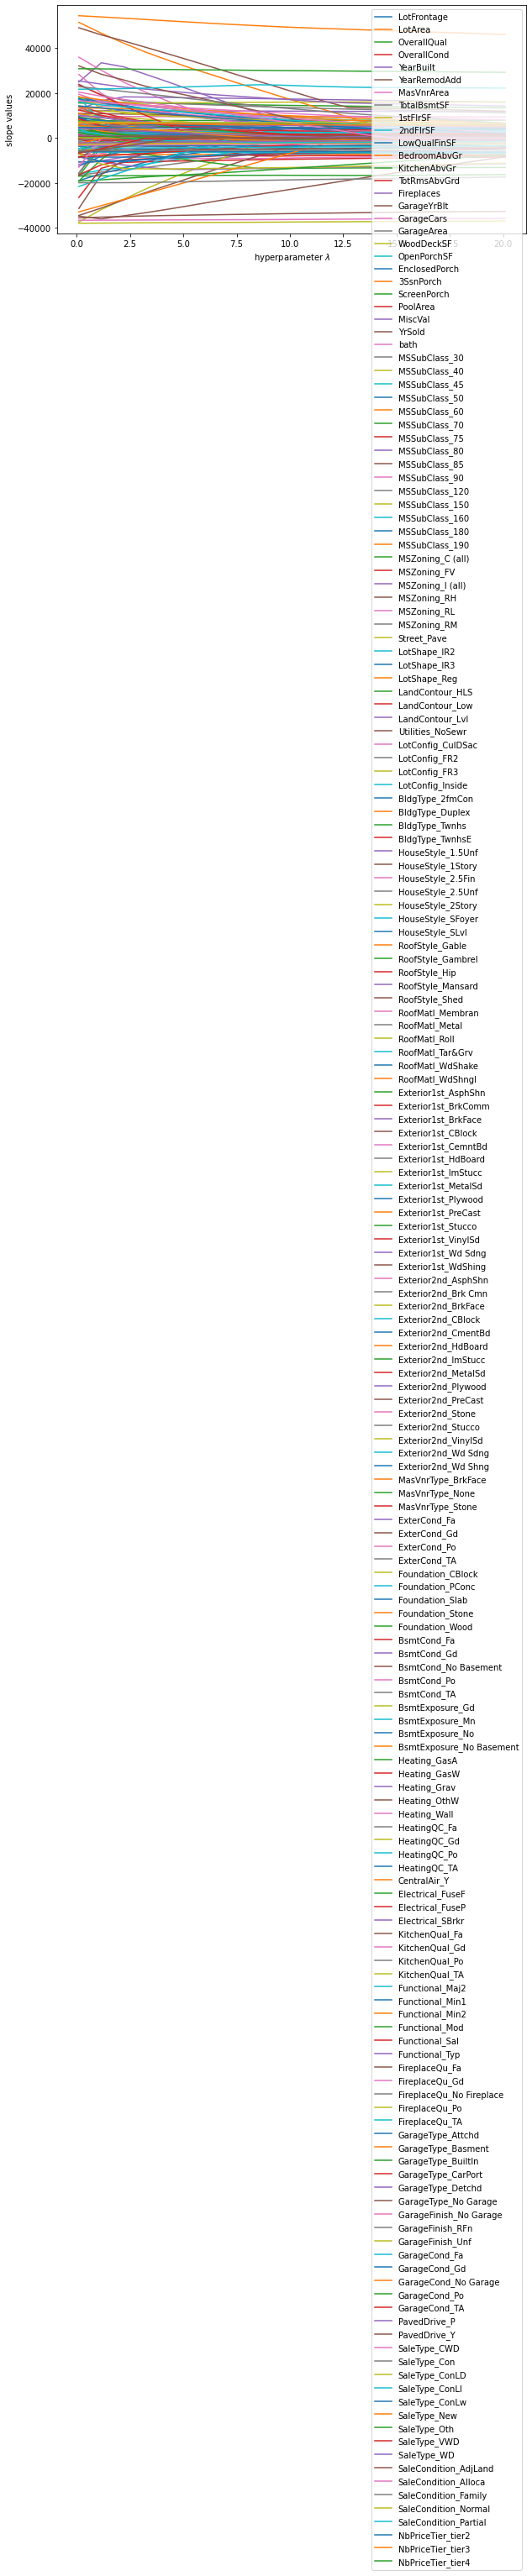

In [74]:
for name in coefs_lasso.columns:
    plt.plot(coefs_lasso.index, coefs_lasso[name], label=name)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')
plt.legend(loc=1)   

In [105]:
#check VIF for numeric features
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['features'] = X_train.columns
vif

# Next fit a lasso, ridge and elastic net 

/Users/chereowang27/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,inf,GrLivArea
1,1.666083e+01,LotFrontage
2,4.589988e+00,LotArea
3,5.709064e+01,OverallQual
4,4.206332e+01,OverallCond
5,1.242434e+04,YearBuilt
6,1.295952e+04,YearRemodAdd
7,1.738771e+00,MasVnrArea
8,inf,BsmtFinSF1
9,inf,BsmtFinSF2


In [136]:
from sklearn.model_selection import GridSearchCV
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
lasso = lasso()
params = {
    "C": [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]
}
gs = GridSearchCV(lasso, params, cv=skfold)
gs.fit(X_train, y_train)
gs.cv_results_['mean_test_score']